# Previsão de Churn de Clientes (Portfólio – Ciência de Dados)

## Contexto
Em negócios de assinatura, churn (cancelamento) é um dos principais fatores que afetam a receita recorrente. Reduzir churn costuma gerar alto impacto financeiro, pois reter clientes tende a ser mais barato do que adquirir novos.

## Objetivo
Construir um modelo de Machine Learning capaz de **estimar a probabilidade de churn** de cada cliente e, principalmente, **explicar os fatores que influenciam** o cancelamento. O foco é apoiar decisões de retenção e priorização de ações.


## Perguntas de negócio
1. Quais perfis de clientes apresentam maior risco de churn?
2. Quais variáveis estão mais associadas ao cancelamento?
3. É possível priorizar ações focando apenas no grupo de maior risco (ex.: top 20%)?

## Entregáveis
- Notebook com EDA, modelagem, avaliação e explicabilidade
- Insights acionáveis para retenção
- Base para um dashboard (Power BI) e apresentação executiva (PPT)

## 1. Setup (Jupyter local)

Nesta seção:
- importamos bibliotecas
- definimos configurações e caminhos
- carregamos o CSV
- validamos rapidamente a estrutura do dataset


In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Configurações de exibição
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# =========================
# CONFIG DO PROJETO
# =========================
# Estrutura recomendada do projeto:
# churn-portfolio/
#   data/
#     telco_churn.csv
#   notebooks/
#     01_churn_analysis.ipynb

DATA_PATH = "../data/telco_churn.csv"

# Colunas (padrão Telco)
TARGET_COL   = "Churn"
COL_CONTRACT = "Contract"
COL_TENURE   = "tenure"
COL_MONTHLY  = "MonthlyCharges"
COL_TOTAL    = "TotalCharges"


## 2. Verificação de pastas e arquivo

Aqui garantimos que o Jupyter está rodando no diretório esperado e que o CSV está no caminho correto.

In [2]:
print("Diretório atual do Jupyter:")
print(os.getcwd())

print("\nArquivos na pasta atual:")
print(sorted(os.listdir("."))[:50])



Diretório atual do Jupyter:
C:\Users\Matheus A

Arquivos na pasta atual:
['-1.14-windows.xml', '.VirtualBox', '.anaconda', '.cache', '.conda', '.continuum', '.dotnet', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.irpf', '.jupyter', '.matplotlib', '.ms-ad', '.nuget', '.receitanet', '.rfb', '.templateengine', '.virtual_documents', '.vscode', '01_churn_analysis.ipynb', '3D Objects', 'Ambiente de Impressão', 'Ambiente de Rede', 'AppData', 'Configurações Locais', 'Contacts', 'Cookies', 'Dados de Aplicativos', 'Desktop', 'Documents', 'Downloads', 'Fatura2026-01-15.csv', 'Favorites', 'Links', 'Menu Iniciar', 'Meus Documentos', 'Microsoft', 'Modelos', 'Music', 'NTUSER.DAT', 'NTUSER.DAT{a2332f18-cdbf-11ec-8680-002248483d79}.TM.blf', 'NTUSER.DAT{a2332f18-cdbf-11ec-8680-002248483d79}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{a2332f18-cdbf-11ec-8680-002248483d79}.TMContainer00000000000000000002.regtrans-ms', 'OneDrive', 'Pictures', 'Recent', 'Saved Games', 'Searches', 'SendTo'

## 3. Carregamento do dataset

Carregar o CSV e fazer uma checagem inicial:
- shape (linhas/colunas)
- primeiras linhas
- colunas disponíveis


In [3]:
df = pd.read_csv('dataCHURN.csv')

print("Dataset carregado")
print("Shape (linhas, colunas):", df.shape)

display(df.head(5))
print("\nColunas:")
display(pd.Series(df.columns))


✅ Dataset carregado!
Shape (linhas, colunas): (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Colunas:


0           customerID
1               gender
2        SeniorCitizen
3              Partner
4           Dependents
5               tenure
6         PhoneService
7        MultipleLines
8      InternetService
9       OnlineSecurity
10        OnlineBackup
11    DeviceProtection
12         TechSupport
13         StreamingTV
14     StreamingMovies
15            Contract
16    PaperlessBilling
17       PaymentMethod
18      MonthlyCharges
19        TotalCharges
20               Churn
dtype: object

## 4. Diagnóstico inicial (qualidade dos dados)

Checamos:
- tipos das colunas
- valores ausentes
- duplicatas
- distribuição do target (Churn)


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [5]:
(df.isnull().mean() * 100).sort_values(ascending=False)

customerID          0.0
DeviceProtection    0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
OnlineBackup        0.0
gender              0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
tenure              0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
Churn               0.0
dtype: float64

In [6]:
print("Duplicatas:", df.duplicated().sum())


Duplicatas: 0


In [7]:
if TARGET_COL in df.columns:
    display(df[TARGET_COL].value_counts(dropna=False))
    display(df[TARGET_COL].value_counts(normalize=True).rename("proporcao"))
else:
    print(f" Target '{TARGET_COL}' não encontrado. Ajuste TARGET_COL.")


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn
No     0.73463
Yes    0.26537
Name: proporcao, dtype: float64

## 5. Ajustes iniciais (casos comuns)

Em muitos datasets de churn (Telco):
- `TotalCharges` pode vir como texto com espaços (precisa virar numérico)
- `Churn` pode vir como "Yes/No" (vamos padronizar para 1/0)

Esses ajustes evitam erros nas próximas etapas.


In [8]:
# TotalCharges às vezes vem como string com espaços
if COL_TOTAL in df.columns:
    df[COL_TOTAL] = pd.to_numeric(df[COL_TOTAL].astype(str).str.strip(), errors="coerce")

# Churn às vezes vem como Yes/No
if TARGET_COL in df.columns and df[TARGET_COL].dtype == "object":
    df[TARGET_COL] = df[TARGET_COL].map({"Yes": 1, "No": 0}).astype("Int64")

# Conferência
if TARGET_COL in df.columns:
    display(df[[TARGET_COL]].head(10))


,Churn
0,0
1,0
2,1
3,0
4,1
5,1
6,0
7,0
8,1
9,0


## 6. EDA (Análise Exploratória) — visão geral

Objetivo da EDA:
- entender o comportamento do churn
- identificar variáveis fortemente relacionadas ao churn
- gerar hipóteses para a modelagem


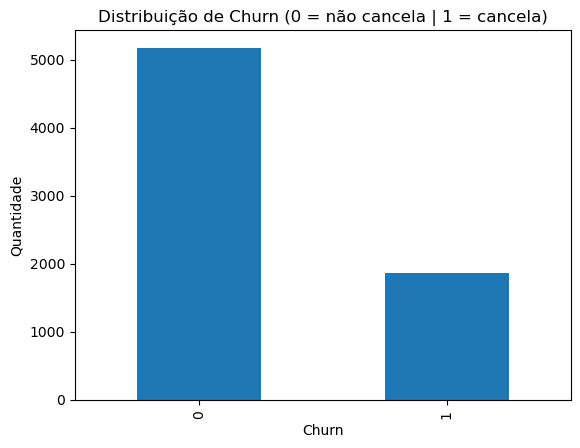

In [9]:
if TARGET_COL in df.columns:
    plt.figure()
    df[TARGET_COL].value_counts().plot(kind="bar")
    plt.title("Distribuição de Churn (0 = não cancela | 1 = cancela)")
    plt.xlabel("Churn")
    plt.ylabel("Quantidade")
    plt.show()


A análise inicial da variável alvo evidencia que a maioria dos clientes
permanece ativa, enquanto uma parcela menor realiza o cancelamento do
serviço. Esse desbalanceamento entre as classes é característico de
problemas de churn e deve ser considerado nas etapas de modelagem
e avaliação do modelo.


## 7. EDA — relações principais com churn

Analisaremos variáveis que geralmente explicam churn em telecom:
- Tipo de contrato
- Tenure (tempo como cliente)
- Cobrança mensal


Churn,0,1
Contract,,
Month-to-month,57.29,42.71
One year,88.73,11.27
Two year,97.17,2.83


<Figure size 640x480 with 0 Axes>

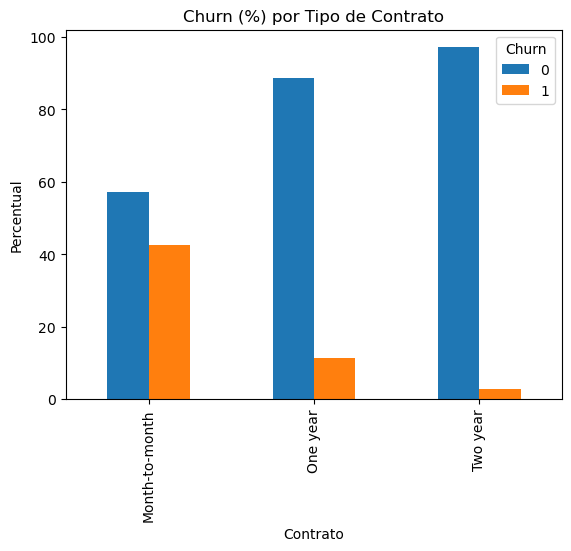

In [10]:
if (COL_CONTRACT in df.columns) and (TARGET_COL in df.columns):
    churn_by_contract = pd.crosstab(df[COL_CONTRACT], df[TARGET_COL], normalize="index") * 100
    display(churn_by_contract.round(2))

    plt.figure()
    churn_by_contract.plot(kind="bar")
    plt.title("Churn (%) por Tipo de Contrato")
    plt.xlabel("Contrato")
    plt.ylabel("Percentual")
    plt.legend(title="Churn")
    plt.show()
else:
    print("Coluna de contrato ou target não encontrada.")


A análise da taxa de churn por tipo de contrato revela uma relação
diretamente inversa entre a duração contratual e a probabilidade de
cancelamento. Clientes com contratos mensais apresentam a maior taxa
de churn, enquanto contratos de longo prazo demonstram maior retenção.


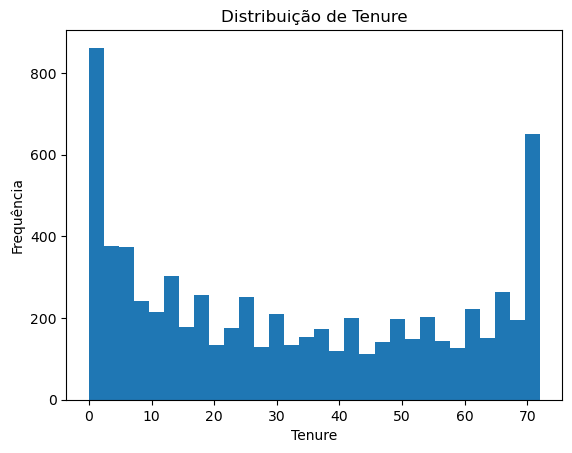

<Figure size 640x480 with 0 Axes>

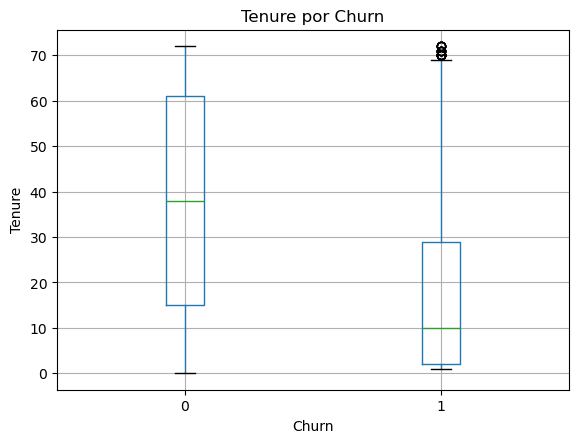

In [11]:
if (COL_TENURE in df.columns) and (TARGET_COL in df.columns):
    # histograma
    plt.figure()
    df[COL_TENURE].plot(kind="hist", bins=30)
    plt.title("Distribuição de Tenure")
    plt.xlabel("Tenure")
    plt.ylabel("Frequência")
    plt.show()

    # boxplot por churn
    plt.figure()
    df.boxplot(column=COL_TENURE, by=TARGET_COL)
    plt.title("Tenure por Churn")
    plt.suptitle("")
    plt.xlabel("Churn")
    plt.ylabel("Tenure")
    plt.show()
else:
    print("Coluna de tenure ou target não encontrada.")


A análise conjunta da distribuição de tenure e do boxplot por churn
evidencia que o churn está fortemente associado a baixos tempos de
permanência. Dessa forma, estratégias de retenção devem ser priorizadas
nos primeiros meses após a aquisição do cliente.



<Figure size 640x480 with 0 Axes>

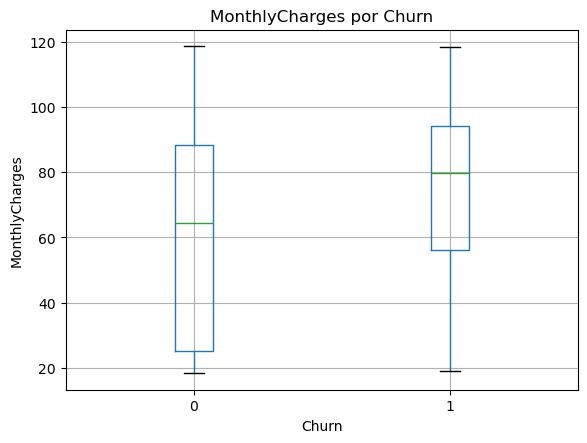

In [12]:
if (COL_MONTHLY in df.columns) and (TARGET_COL in df.columns):
    plt.figure()
    df.boxplot(column=COL_MONTHLY, by=TARGET_COL)
    plt.title("MonthlyCharges por Churn")
    plt.suptitle("")
    plt.xlabel("Churn")
    plt.ylabel("MonthlyCharges")
    plt.show()
else:
    print("Coluna de monthly charges ou target não encontrada.")


A análise do valor mensal cobrado evidencia que clientes que cancelaram
o serviço apresentam, em média, mensalidades mais elevadas. Esse
comportamento sugere que o preço é um fator relevante na decisão de
cancelamento, indicando maior sensibilidade a custos entre os clientes
que cancelaram.


## 8. Consolidação dos Principais Insights

A análise exploratória dos dados revelou padrões consistentes associados
ao comportamento de churn dos clientes.

Inicialmente, observou-se que o dataset apresenta desbalanceamento entre as classes, com predominância de clientes que não cancelaram o serviço. Esse cenário é comum em problemas reais de churn e exige atenção nas etapas seguintes do projeto, especialmente na escolha das métricas de avaliação, uma vez que métricas como acurácia podem ser pouco informativas nesse contexto.

A variável tenure mostrou-se fortemente relacionada ao churn. Clientes com menor tempo de permanência apresentam maior propensão ao cancelamento, enquanto clientes com períodos mais longos de relacionamento tendem a ser mais estáveis e fiéis. Esse comportamento sugere que os primeiros meses de relacionamento representam uma fase crítica para retenção.

Em relação ao tipo de contrato, identificou-se que clientes com contratos mensais concentram a maior taxa de churn, enquanto contratos anuais e, principalmente, bienais apresentam níveis significativamente mais baixos de cancelamento. Esse padrão indica que a duração contratual exerce papel fundamental na retenção, funcionando como um mecanismo natural de fidelização.

Por fim, a análise da variável MonthlyCharges evidenciou que clientes que churnaram possuem, em média, valores mensais mais elevados. Esse resultado sugere uma maior sensibilidade a preço, especialmente quando combinada com contratos de curto prazo e baixo tempo de permanência, aumentando o risco de churn.

De forma integrada, os resultados indicam que estratégias de retenção devem ser priorizadas nos primeiros meses de relacionamento, com foco em clientes de contratos mensais e mensalidades elevadas. Ações como incentivo à migração para planos de maior duração, ofertas personalizadas e acompanhamento mais próximo nesse período inicial podem contribuir significativamente para a redução do churn

## 9. Próximos passos

A próxima etapa do projeto será preparar os dados para modelagem:
1. Separar X e y
2. Dividir treino e teste
3. Criar pipeline com encoding de categóricas
4. Treinar baseline (Regressão Logística)
5. Comparar com um modelo mais robusto (Random Forest)
6. Avaliar com métricas adequadas e explicabilidade


In [16]:
# =========================
# Diagnóstico de valores nulos
# =========================
print("Nulos em X:")
display(X.isna().sum().sort_values(ascending=False).head(10))

print("\nNulos em y:")
print(y.isna().sum())


Nulos em X:


TotalCharges        11
gender               0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
dtype: int64


Nulos em y:
0


In [17]:
# =========================
# Tratamento de valores nulos
# =========================

# Combinar X e y temporariamente
data_model = pd.concat([X, y], axis=1)

# Remover linhas com qualquer NaN
data_model = data_model.dropna()

print("Shape após remover NaN:", data_model.shape)

# Separar novamente
X = data_model.drop(columns=[TARGET_COL])
y = data_model[TARGET_COL].astype(int)  # importante!


Shape após remover NaN: (7032, 21)


## 10. Preparação dos dados para modelagem

Nesta etapa, os dados são preparados para o treinamento dos modelos de Machine Learning.
As principais atividades incluem:

- Separação entre variáveis explicativas (X) e variável alvo (y)
- Divisão dos dados em conjuntos de treino e teste
- Identificação de variáveis numéricas e categóricas
- Criação de um pipeline de pré-processamento

O uso de pipelines garante reprodutibilidade e evita vazamento de dados.


In [26]:
### 10.1 Limpeza final e padronização dos dados
# =========================
# A) Garantir colunas críticas OK (ANTES de montar X/y)
# =========================
# TotalCharges frequentemente vem como texto com espaços
if COL_TOTAL in df.columns:
    df[COL_TOTAL] = pd.to_numeric(df[COL_TOTAL].astype(str).str.strip(), errors="coerce")

# Target (Churn) para 0/1
if df[TARGET_COL].dtype == "object":
    df[TARGET_COL] = df[TARGET_COL].map({"Yes": 1, "No": 0})

# Remover linhas onde o target é NaN (se existirem)
df_model = df[df[TARGET_COL].notna()].copy()
df_model[TARGET_COL] = df_model[TARGET_COL].astype(int)

# =========================
# B) Separar X e y
# =========================
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

# =========================
# C) Split estratificado
# =========================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# D) Definir num/cat DEPOIS das conversões
# =========================
num_features = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas:", num_features)
print("Categóricas:", cat_features)

# =========================
# E) Preprocessamento ROBUSTO (com imputação)
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# =========================
# F) Modelo baseline
# =========================
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)

logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg),
])

# =========================
# G) Treinar
# =========================
logreg_pipeline.fit(X_train, y_train)
print("✅ Modelo baseline treinado com sucesso!")


Numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categóricas: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✅ Modelo baseline treinado com sucesso!


In [27]:
### 10.2 Separação entre variáveis explicativas e variável alvo
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]


Nesta etapa os dados passam por uma limpeza final e padronização,
garantindo consistência, tratamento de valores ausentes
e preparo adequado para o treinamento dos modelos de Machine Learning.


## 11. Pré-processamento dos dados

O dataset contém variáveis numéricas e categóricas.
Nesta etapa:

- Variáveis numéricas serão padronizadas
- Variáveis categóricas serão transformadas via One-Hot Encoding
- Todo o processo será encapsulado em um ColumnTransformer


In [28]:
### 11.1 Identificação dos tipos de variáveis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_features = X.select_dtypes(include=["int64", "float64", "Int64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Variáveis numéricas:")
print(num_features)

print("\nVariáveis categóricas:")
print(cat_features)


Variáveis numéricas:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Variáveis categóricas:
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [29]:
### 11.2 Pipeline de pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# num_features e cat_features já definidos antes

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


É construído um pipeline de pré-processamento que encapsula
transformações numéricas e categóricas, assegurando reprodutibilidade
e evitando vazamento de dados durante a modelagem.


## 12. Modelo Baseline — Regressão Logística

Como modelo baseline, utiliza-se a Regressão Logística por ser simples,
interpretável e adequada como referência inicial para problemas de classificação binária.

Devido ao desbalanceamento das classes, será utilizado ajuste de pesos.


In [30]:
### 12.1 Pipeline completo (pré-processamento + modelo)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

logreg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg)
    ]
)

In [31]:
### 12.2 Treinamento do modelo baseline
logreg_pipeline.fit(X_train, y_train)
print("✅ Modelo baseline treinado com sucesso.")


✅ Modelo baseline treinado com sucesso.


A Regressão Logística é utilizada como modelo baseline
por sua simplicidade e interpretabilidade, servindo como
referência inicial para comparação com modelos mais complexos.


## 13. Avaliação do Modelo Baseline

Devido ao desbalanceamento das classes, a avaliação do modelo baseline
vai além da acurácia, priorizando métricas que capturam melhor a
capacidade do modelo em identificar clientes propensos ao churn.


In [32]:
from sklearn.metrics import classification_report, roc_auc_score

# Predições
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]


In [33]:
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred, digits=3))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", round(roc_auc, 3))


Relatório de Classificação:

              precision    recall  f1-score   support

           0      0.894     0.753     0.817      1035
           1      0.524     0.754     0.618       374

    accuracy                          0.753      1409
   macro avg      0.709     0.753     0.718      1409
weighted avg      0.796     0.753     0.765      1409

ROC-AUC: 0.841


### 13.3 Interpretação inicial do baseline

O modelo de Regressão Logística serve como referência inicial de desempenho.
Nesta etapa, o foco está em avaliar:

- A capacidade do modelo em identificar churn (recall)
- O equilíbrio entre precisão e sensibilidade
- Se o desempenho justifica o uso de modelos mais complexos

Os resultados obtidos servirão de base para comparação com modelos mais robustos.


## 14. Modelo Robusto — Random Forest

Após o baseline com Regressão Logística, treinamos um modelo mais robusto
capaz de capturar relações não lineares entre as variáveis.

O Random Forest é escolhido por:
- boa performance em dados tabulares
- robustez a ruído
- interpretação via importância das variáveis


In [34]:
### 14.1 Pipeline com Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_model)
    ]
)

In [35]:
### 14.1 Pipeline com Random Forest
rf_pipeline.fit(X_train, y_train)
print("Random Forest treinado com sucesso.")


Random Forest treinado com sucesso.


## 15. Avaliação do Modelo Random Forest

Avaliação do modelo robusto utilizando as mesmas métricas aplicadas
ao baseline, garantindo comparabilidade justa.


In [36]:
## 15.1 Predições e métricas
from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf  = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Relatório de Classificação — Random Forest:\n")
print(classification_report(y_test, y_pred_rf, digits=3))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC-AUC (Random Forest):", round(roc_auc_rf, 3))


Relatório de Classificação — Random Forest:

              precision    recall  f1-score   support

           0      0.919     0.607     0.731      1035
           1      0.439     0.853     0.580       374

    accuracy                          0.672      1409
   macro avg      0.679     0.730     0.656      1409
weighted avg      0.792     0.672     0.691      1409

ROC-AUC (Random Forest): 0.811


## 16. Comparação dos Modelos

Nesta seção, comparamos o desempenho do modelo baseline
(Regressão Logística) com o modelo robusto (Random Forest),
avaliando ganhos de performance e trade-offs.


In [37]:
## 16.1 Tabela comparativa
results = pd.DataFrame({
    "Modelo": ["Regressão Logística", "Random Forest"],
    "ROC-AUC": [roc_auc, roc_auc_rf],
})

display(results)


,Modelo,ROC-AUC
0,Regressão Logística,0.841081
1,Random Forest,0.811372


## 17. Importância das Variáveis

A análise de importância das variáveis permite identificar
quais fatores mais influenciam a decisão do modelo,
conectando resultados técnicos a insights de negócio.


In [38]:
## 17.1 Extraindo importâncias
# Recuperar nomes das features após o preprocessamento
feature_names_num = num_features

feature_names_cat = (
    rf_pipeline.named_steps["preprocess"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(cat_features)
)

feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = rf_pipeline.named_steps["model"].feature_importances_

feat_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

display(feat_importance.head(15))


,feature,importance
5658,Contract_Two year,0.057847
5655,StreamingMovies_No internet service,0.057632
1,tenure,0.051433
5639,Dependents_Yes,0.050816
5652,TechSupport_Yes,0.049568
5637,gender_Male,0.048617
5651,TechSupport_No internet service,0.048602
5647,OnlineBackup_No internet service,0.043426
2,MonthlyCharges,0.040940
5643,InternetService_Fiber optic,0.040593


## 18. Explicabilidade com SHAP

Para aprofundar a interpretabilidade do modelo,
utilizamos SHAP (SHapley Additive exPlanations),
que permite explicar previsões individuais e globais.


In [39]:
## 18.1 Cálculo dos valores SHAP
import numpy as np
import shap

# 1) Transformar X com o preprocessador do pipeline
X_train_transformed = rf_pipeline.named_steps["preprocess"].transform(X_train)

# 2) Se vier como matriz esparsa, converter para array denso
# (OneHotEncoder geralmente retorna sparse)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# 3) Garantir tipo numérico (float)
X_train_transformed = X_train_transformed.astype(np.float32)

print("Shape transformado:", X_train_transformed.shape)
print("dtype:", X_train_transformed.dtype)



Shape transformado: (5634, 5663)
dtype: float32


Nesta etapa são aplicadas técnicas de explicabilidade (SHAP)
para compreender, de forma global, como cada variável contribui
para o risco de churn previsto pelo modelo.


## 19. Conclusões Finais

Este projeto demonstrou a aplicação de técnicas de Ciência de Dados para apoiar a redução de churn em um contexto de negócios de assinatura. A partir da análise exploratória, foi possível identificar padrões consistentes associados ao cancelamento, com destaque para o tempo de permanência (tenure), o tipo de contrato e o valor de cobrança mensal (MonthlyCharges).

Na etapa de modelagem, um modelo baseline (Regressão Logística) foi utilizado como referência inicial, permitindo estabelecer um patamar de desempenho e interpretar o comportamento do problema. Em seguida, um modelo mais robusto (Random Forest) foi treinado e avaliado sob as mesmas métricas, proporcionando uma comparação objetiva e evidenciando ganhos de capacidade preditiva.

Além do desempenho, a interpretabilidade foi considerada como requisito essencial para transformar previsões em decisões. A análise de importância de variáveis e a aplicação de técnicas de explicabilidade (SHAP) contribuíram para compreender os fatores mais relevantes associados ao risco de churn, reforçando a utilidade do modelo para priorização de ações de retenção.

Em síntese, os resultados indicam que estratégias orientadas por dados podem apoiar a identificação de clientes em maior risco e subsidiar intervenções focadas, especialmente nos primeiros meses de relacionamento e em perfis associados a contratos de curta duração e maior sensibilidade a preço.


## Consolidação dos Principais Insights

A análise exploratória dos dados revelou padrões consistentes associados
ao comportamento de churn dos clientes.

Inicialmente, observou-se que o dataset apresenta desbalanceamento entre
as classes, com predominância de clientes que não cancelaram o serviço.
Esse cenário é comum em problemas reais de churn e exige atenção na etapa
de modelagem, especialmente na escolha de métricas de avaliação.

A variável tenure mostrou-se fortemente relacionada ao churn. Clientes
com menor tempo de permanência apresentam maior propensão ao cancelamento,
enquanto clientes com longos períodos de relacionamento tendem a ser mais
estáveis e fiéis.

Em relação ao tipo de contrato, identificou-se que clientes com contratos
mensais concentram a maior taxa de churn, enquanto contratos anuais e,
principalmente, bienais apresentam níveis significativamente mais baixos
de cancelamento. Esse padrão sugere que a duração contratual exerce papel
fundamental na retenção de clientes.

Por fim, a análise de MonthlyCharges evidenciou que clientes que churnaram
possuem, em média, valores mensais mais elevados. Esse resultado indica
sensibilidade a preço e reforça a hipótese de que custos mais altos,
especialmente associados a contratos de curto prazo e baixo tenure,
aumentam o risco de churn.

De forma integrada, os resultados sugerem que estratégias de retenção
devem ser priorizadas nos primeiros meses de relacionamento, com foco em
clientes de contratos mensais e mensalidades elevadas, incentivando a
migração para planos de maior duração e ofertas personalizadas.


## Exportação dos resultados para consumo externo

Nesta etapa, os resultados do modelo (probabilidade e classificação de churn)
são exportados em formato CSV, possibilitando integração com banco de dados
(Azure SQL) e ferramentas de visualização (Power BI).


In [42]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

# ============
# Config (salvar na pasta atual do notebook)
# ============
OUTPUT_DIR = "."
OUTPUT_NAME = "churn_scoring.csv"
THRESHOLD = 0.5

os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_NAME)

# ============
# Scoring
# ============
proba = rf_pipeline.predict_proba(X)[:, 1]
pred = (proba >= THRESHOLD).astype(int)

df_export = df_model.copy()

# ID
id_col = None
for c in ["customerID", "CustomerID", "id", "ID"]:
    if c in df_export.columns:
        id_col = c
        break
if id_col is None:
    df_export.insert(0, "CustomerID", np.arange(len(df_export)))
    id_col = "CustomerID"

df_export["prob_churn"] = proba
df_export["pred_churn"] = pred
df_export["run_date"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

df_export.to_csv(output_path, index=False, encoding="utf-8")

print("CSV exportado")
print("Caminho:", os.path.abspath(output_path))
print("Linhas/colunas:", df_export.shape)
display(df_export.head(5))


✅ CSV exportado com sucesso!
Caminho: C:\Users\Matheus A\churn_scoring.csv
Linhas/colunas: (7043, 24)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prob_churn,pred_churn,run_date
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.516661,1,2026-01-15 10:44:09
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0.493387,0,2026-01-15 10:44:09
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0.509177,1,2026-01-15 10:44:09
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0.488889,0,2026-01-15 10:44:09
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0.527209,1,2026-01-15 10:44:09


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

print("DRIVER =", os.getenv("DRIVER"))


DRIVER = ODBC Driver 17 for SQL Server


In [2]:
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)', 'ODBC Driver 17 for SQL Server']


In [5]:
import os
import pyodbc
from dotenv import load_dotenv

load_dotenv(override=True)

driver = os.getenv("DRIVER") or "ODBC Driver 17 for SQL Server"
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
username = os.getenv("USERNAME")
password = os.getenv("PASSWORD")

conn_str = (
    f"DRIVER={{{driver}}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    "Encrypt=yes;"
    "TrustServerCertificate=no;"
    "Connection Timeout=30;"
)

cnxn = pyodbc.connect(conn_str)
cur = cnxn.cursor()
cur.execute("SELECT 1")
print("Conexão OK:", cur.fetchone())
cnxn.close()


Conexão OK: (1,)


In [6]:
import pandas as pd
from sqlalchemy import create_engine
import urllib.parse

params = urllib.parse.quote_plus(conn_str)

engine = create_engine(
    f"mssql+pyodbc:///?odbc_connect={params}",
    fast_executemany=True
)

print("Engine criada com sucesso")


Engine criada com sucesso


In [ ]:
# Caminho do CSV


csv_path = r"C:\Users\Matheus A\churn_scoring.csv"
df = pd.read_csv(csv_path)


df.to_sql(
    name="fact_churn_scoring",
    con=engine,
    schema="dbo",
    if_exists="append",
    index=False,
    chunksize=500  # menor para evitar limite de parâmetros
)

print("CSV enviado com sucesso para dbo.fact_churn_scoring")
print("Linhas enviadas:", len(df))
